In [1]:
import os
import copy
from typing import Type, Dict, List, Tuple, Optional

import matplotlib.pyplot as plt
import torch
import pyro
import seaborn as sns
import torch
import contextlib
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from pyro.infer.autoguide import AutoDiagonalNormal
from chirho.robust.handlers.predictive import PredictiveModel

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

import pyro

from chirho.interventional.handlers import do
from cities.modeling.simple_linear import SimpleLinear, RegisterInput
from cities.modeling.add_categorical_interactions import AddCategoricalInteractions
from cities.modeling.add_causal_layer import AddCausalLayer 
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data
from pyro.infer import Predictive

import contextlib


smoke_test = "CI" in os.environ
n = 20 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000
n_steps = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:
n = 600
part = n // 3
n_steps = 600

x_cat = torch.cat(
    [
        torch.zeros([part], dtype=torch.long),
        torch.ones([part], dtype=torch.long),
        2 * torch.ones([part], dtype=torch.long),
    ]
)
x_con = torch.cat([torch.ones(n//2), torch.ones(n//2) * 2]) + torch.randn(n) * 0.1 + 0.5 * x_cat 


y_mixed = x_cat * 2 + x_con * 2 + torch.randn(n) * 0.05

synthetic_minimal_outcome = {
    "categorical": {"x_cat": x_cat},
    "continuous": {"x_con": x_con, "y_mixed": y_mixed   },
    "outcome": y_mixed,
}

minimal_kwargs_synthetic = {
    "categorical": {"x_cat"},
    "continuous": {"x_con"},
    "outcome": "y_mixed",
}

synthetic_minimal = copy.deepcopy(synthetic_minimal_outcome)
synthetic_minimal['outcome'] = None



[iteration 0001] loss: 13831.5996
[iteration 0050] loss: 969.9341
[iteration 0100] loss: 825.0463
[iteration 0150] loss: 804.1437
[iteration 0200] loss: 786.3796
[iteration 0250] loss: 450.8284
[iteration 0300] loss: 356.1717
[iteration 0350] loss: 194.4171
[iteration 0400] loss: 254.5763
[iteration 0450] loss: -2.5645
[iteration 0500] loss: -28.5769
[iteration 0550] loss: 165.8194
[iteration 0600] loss: -403.6441


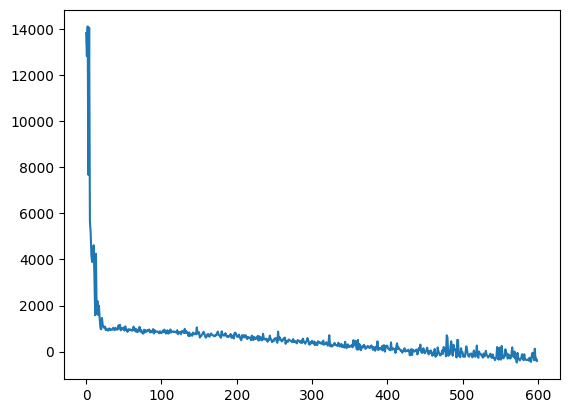

In [3]:
base_model_synthetic = SimpleLinear(**synthetic_minimal_outcome)


base_guide = run_svi_inference(base_model_synthetic, **synthetic_minimal_outcome, n_steps=600)

predictive = Predictive(base_model_synthetic, guide=base_guide, num_samples=1000)

predictive_model = PredictiveModel(base_model_synthetic, base_guide)

torch.Size([600])


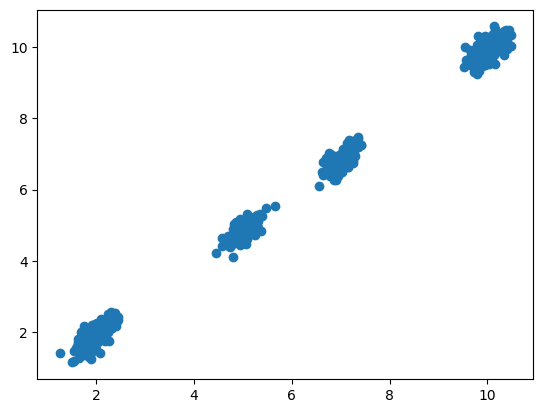

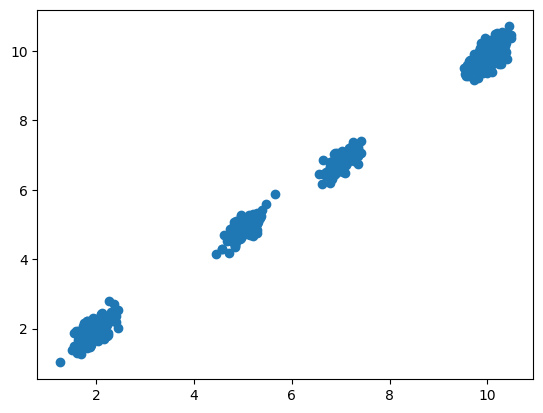

In [4]:
samples = predictive(**synthetic_minimal)
samples_model = predictive_model(**synthetic_minimal)

print(
samples['outcome_observed'][0,:].shape 
)

plt.scatter(synthetic_minimal_outcome['outcome'], samples['outcome_observed'][0,:])
plt.show()


plt.scatter(synthetic_minimal_outcome['outcome'], samples_model.detach().numpy())
plt.show()


[iteration 0001] loss: 20159.3984
[iteration 0050] loss: 2147.8118
[iteration 0100] loss: 1444.1663
[iteration 0150] loss: 975.1116
[iteration 0200] loss: 758.2514
[iteration 0250] loss: 770.4822
[iteration 0300] loss: 551.3272
[iteration 0350] loss: 514.9880
[iteration 0400] loss: 369.0171
[iteration 0450] loss: 373.1762
[iteration 0500] loss: 216.8257
[iteration 0550] loss: -118.1851
[iteration 0600] loss: 11.8333


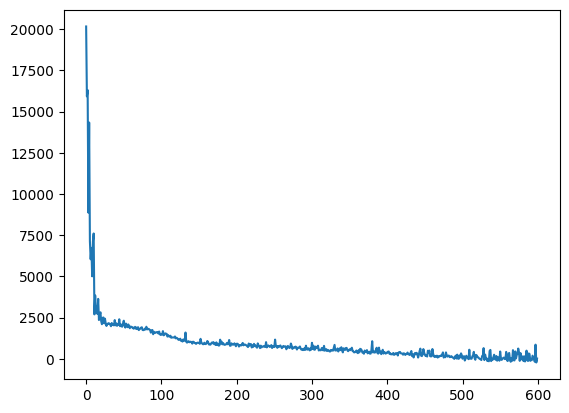

In [5]:
base_model_synthetic = SimpleLinear(**synthetic_minimal_outcome)

def new_model_synthetic(**kwargs):
    with AddCausalLayer(
        base_model_synthetic,
        model_kwargs=minimal_kwargs_synthetic,
        dataset=synthetic_minimal_outcome,
        causal_layer={"x_con": ["x_cat"]},
    ):
        base_model_synthetic(**kwargs)

new_guide_synthetic = run_svi_inference(
    new_model_synthetic,  **synthetic_minimal_outcome, n_steps=600) 


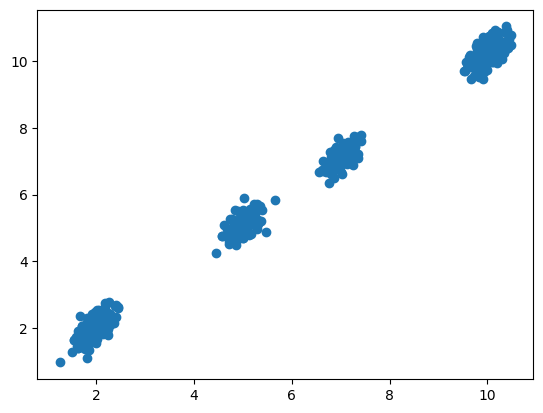

None


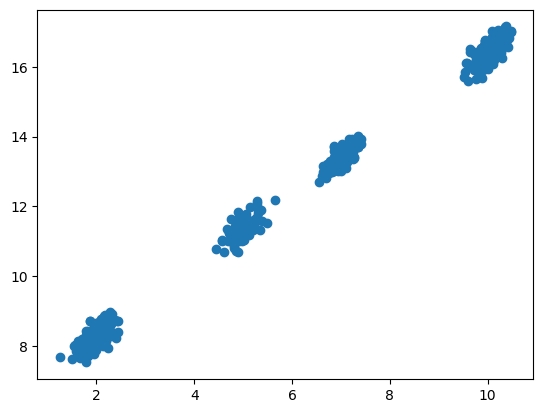

In [6]:
predictive_model_synthetic = PredictiveModel(
new_model_synthetic, guide=new_guide_synthetic)

# note, this will fail:
# predictive_model_synthetic = Predictive(
# new_model_synthetic, guide=new_guide_synthetic, num_samples = 1)

samples_synthetic = predictive_model_synthetic(categorical = {"x_cat": x_cat}, 
                                         continuous={"x_con": x_con}, 
                                         outcome=None)

# this will fail
#assert samples_synthetic is not None


with pyro.poutine.trace() as tr:
    samples_synthetic = predictive_model_synthetic(**synthetic_minimal)

plt.scatter(synthetic_minimal_outcome['outcome'], tr.trace.nodes['outcome_observed']['value'].detach().squeeze())
plt.show()

print(samples_synthetic)
# why none, instead the ones in the trace?

# now let's try the same within a plate
# question why 10, 10, instead of just 10 if within pyro plate?
# question why overblown values if within pyro plate?
with pyro.poutine.trace() as tr:
    with pyro.plate("samples", size = 10, dim = -20):
        samples_synthetic = predictive_model_synthetic(**synthetic_minimal)
plt.scatter(synthetic_minimal_outcome['outcome'], tr.trace.nodes['outcome_observed']['value'].detach().squeeze()[6,6,:])
plt.show()

In [7]:
# now with interventions

with MultiWorldCounterfactual():
    with do(actions={"weights_categorical_x_cat": torch.tensor([10.0]).expand(3)}):
        with pyro.poutine.trace() as tr_after_mwc:
            predictive_model_synthetic(
                categorical={"x_cat": x_cat}, continuous={"x_con": x_con}, outcome=None
            )

print(tr_after_mwc.trace.nodes["weights_categorical_x_cat"][
        "value"
    ])

assert torch.allclose(tr_after_mwc.trace.nodes["weights_categorical_x_cat"]['value'].detach().squeeze()[1,:], torch.tensor([10.0]))

tensor([[[[[[-0.6798,  0.0656,  0.7604]]]]],




        [[[[[10.0000, 10.0000, 10.0000]]]]]], grad_fn=<IndexPutBackward0>)


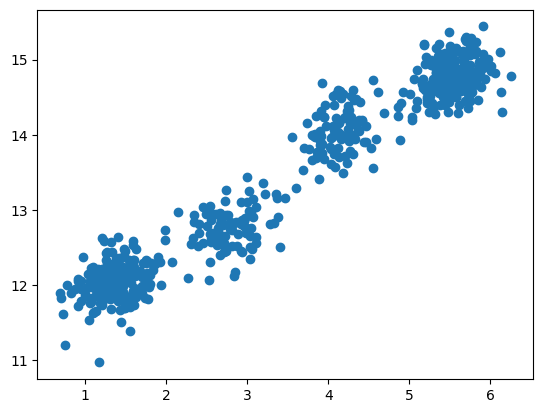

In [8]:
outcome_values = tr_after_mwc.trace.nodes['outcome_observed']['value'].squeeze()

before = outcome_values[0,:].detach().numpy()
after = outcome_values[1,:].detach().numpy()

plt.scatter(x = before, y = after)

assert (after - before > 6).all()

In [9]:
print(tr_after_mwc.trace.nodes.keys())

odict_keys(['AutoMultivariateNormal.scale', 'AutoMultivariateNormal.scale_tril', 'AutoMultivariateNormal.loc', '_AutoMultivariateNormal_latent', 'weights_categorical_x_cat_x_con', 'sigma_x_con', 'sigma', 'weights_categorical_x_cat', 'bias_continuous', 'weight_continuous', 'data_1', 'mean_outcome_prediction_x_con', 'x_con', 'data', 'mean_outcome_prediction', 'outcome_observed'])


In [11]:
with RegisterInput(
        predictive_model_synthetic,
        new_kwargs={
            "categorical": {"x_cat": x_cat},
        },
    ):
        with do(actions={"x_cat": torch.tensor([2]).expand(4)}):
            with pyro.poutine.trace() as tr_registered:
                predictive_model_synthetic(
                    categorical={"x_cat": x_cat}, continuous={"x_con": x_con}, outcome=None
                )

RuntimeError: Multiple sample sites named 'x_cat'

In [40]:
# Now with real data

zoning_data_path = os.path.join(root, "data/minneapolis/processed/zoning_dataset.pt")

zoning_dataset_read = torch.load(zoning_data_path)

zoning_loader = DataLoader(
    zoning_dataset_read, batch_size=len(zoning_dataset_read), shuffle=True
)

data = next(iter(zoning_loader))

print(data['continuous'].keys())

print(data['categorical'].keys())
print(data['continuous'].keys())


minimal_kwargs = {  
    "categorical": ["past_reform"],
    "continuous": {"parcel_area"},
    "outcome": "housing_units",
}

minimal_subset = select_from_data(data, minimal_kwargs)

# will want to add zone_id -> parcel_area and zone_id -> housing_units
expanded_kwargs = {  
    "categorical": ["zone_id", "past_reform"],
    "continuous": {"parcel_area"},
    "outcome": "housing_units",
}

expanded_subset = select_from_data(data, expanded_kwargs)


dict_keys(['parcel_area', 'car_parking', 'housing_units', 'parcel_area_original', 'car_parking_original', 'housing_units_original'])
dict_keys(['parcel_id', 'neighborhood_id', 'ward_id', 'zone_id', 'limit_id', 'past_reform', 'year', 'month'])
dict_keys(['parcel_area', 'car_parking', 'housing_units', 'parcel_area_original', 'car_parking_original', 'housing_units_original'])
torch.Size([302])


In [41]:
base_model = SimpleLinear(**minimal_subset)

base_model(**minimal_subset)
print(minimal_subset['categorical'].keys())
print(minimal_subset['continuous'].keys())

dict_keys(['past_reform'])
dict_keys(['parcel_area'])


[iteration 0001] loss: 89613.1484
[iteration 0050] loss: 8186.8926
[iteration 0100] loss: 2252.6123
[iteration 0150] loss: 2123.8411
[iteration 0200] loss: 1924.0337
[iteration 0250] loss: 2007.0758
[iteration 0300] loss: 1864.1340
[iteration 0350] loss: 2286.2236
[iteration 0400] loss: 1767.9724
[iteration 0450] loss: 2156.9639
[iteration 0500] loss: 1747.1337


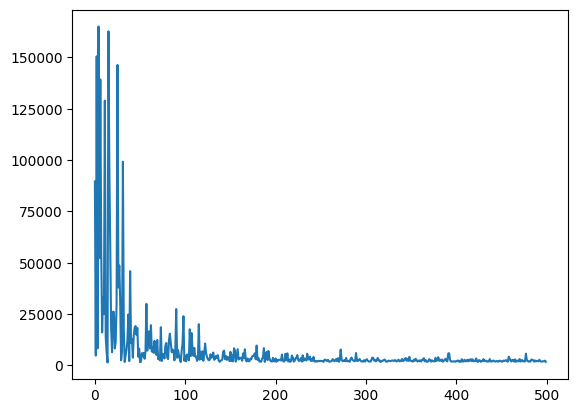

In [64]:
# minimal with non-trivial causal layer
# bad idea to have car_parking_original
# here just as a placeholder

def new_model(**kwargs):
    with AddCausalLayer(base_model,
        model_kwargs = minimal_kwargs,
        dataset = data,
        causal_layer={"parcel_area": ["zone_id", "neighborhood_id", "car_parking_original"], "housing_units": ["zone_id", "car_parking_original"]}):
            base_model(**kwargs)

with pyro.poutine.trace() as tr:
    new_model(**minimal_subset)

assert torch.allclose(tr.trace.nodes['parcel_area']['value'], data['continuous']['parcel_area'])
assert torch.allclose(tr.trace.nodes['outcome_observed']['value'], data['continuous']['housing_units'])


pyro.clear_param_store()

new_guide = run_svi_inference(new_model, **minimal_subset)


In [84]:
predictive = PredictiveModel(
    new_model, guide=new_guide)

minimal_subset_no_outcome = copy.deepcopy(minimal_subset)
minimal_subset_no_outcome['outcome'] = None

#print(minimal_subset['outcome'])

with pyro.plate("samples", size = 10, dim = -10):
    with pyro.poutine.trace() as tr_with_plate:
        predictive(**minimal_subset_no_outcome)

with pyro.poutine.trace() as tr:
    predictive(**minimal_subset_no_outcome)

assert torch.allclose(tr_with_plate.trace.nodes['outcome_observed']['value'].detach().squeeze()[2,0,:], minimal_subset['outcome'], atol=7)
assert torch.allclose(tr.trace.nodes['outcome_observed']['value'].detach().squeeze(), minimal_subset['outcome'], atol=7)
assert not torch.allclose(tr.trace.nodes['outcome_observed']['value'].detach().squeeze(), minimal_subset['outcome'], atol=0.2)